In [426]:
# Here I calculate the average number of near-cognate tRNAs per tRNA
# tRNAs and their respective codons are obtained from Dong et al. (1996)

from xlrd import open_workbook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import Bio
from Bio.Alphabet import generic_dna
from Bio.Seq import reverse_complement,transcribe,back_transcribe
import matplotlib.pyplot as plt

book = open_workbook('/Users/Akshay/Dropbox/Life/Research/EndyLab/Research/Simulations/TranslationDynamics/calculations/tRNARecognitionPatterns.xlsx')
sheet = book.sheet_by_index(0)

# read header values into the list    
keys = [sheet.cell(row_index, 0).value for row_index in range(sheet.nrows)]
dict = {}
dict_maincodon={}
for row_index in range(0, sheet.nrows):
    codon_list = []
    for col_index in range(1,4):
        codon = sheet.cell(row_index,col_index).value
        if codon:
            codon_list.append(codon)
    dict[sheet.cell(row_index,0).value] = codon_list
    for col_index in range(4,5):
        anticodon = transcribe(reverse_complement(back_transcribe((sheet.cell(row_index,col_index).value))))
        dict_maincodon[sheet.cell(row_index,0).value]= anticodon


In [196]:
#Recreates Rodnina 2014 Fig 2
bases = ['G','A','U','C']
codonlist = [a+b+c for a in bases for b in bases for c in bases]


proximity_grid = -np.ones((len(codonlist),len(dict.keys())))
i=0
for codon in codonlist:
    j=0
    for tRNA1 in dict.keys():
        max_neighbors=-1
        for tRNA_codon in dict[tRNA1]:
            max_neighbors=neighbor_count(codon,tRNA_codon)
            if max_neighbors>proximity_grid[i,j]:
                proximity_grid[i,j] = max_neighbors
        j+=1
    i+=1

In [197]:
def neighbor_count(string1,string2):
    count_diffs = 0
    for a, b in zip(string1, string2):
        if a!=b:
            count_diffs += 1
    if count_diffs==0: ##cognate
        return 1
    if count_diffs ==1: ##near-cognate
        return 0
    if count_diffs>1: ##non-cognate
        return -1


In [213]:
cog_grid=np.zeros((len(codonlist),3))
for i in range(len(proximity_grid)):
    cog_grid[i,0]=(proximity_grid[i]==1).sum()
    cog_grid[i,1]=(proximity_grid[i]==0).sum()
    cog_grid[i,2]=(proximity_grid[i]==-1).sum()

In [220]:
np.set_printoptions(threshold=1000)
np.average(cog_grid,axis=0)


array([  1.15625,   8.40625,  32.4375 ])

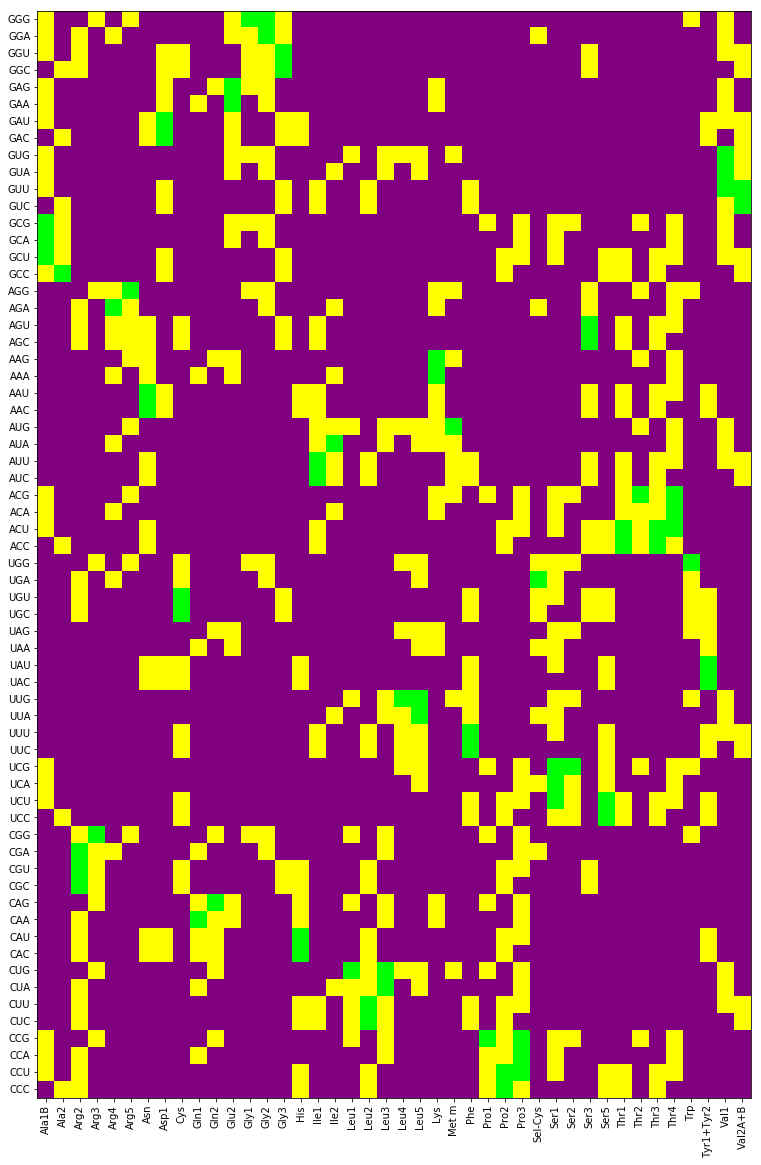

In [198]:
fig, ax1 = plt.subplots(figsize=(20, 20))
ax1.imshow(proximity_grid,cmap=colors.ListedColormap(['purple','yellow','lime']))
ax1.set_yticks(range(0,64));
ax1.set_yticklabels(codonlist);
ax1.set_xticks(range(0,42));
plt.xticks(rotation=90)
ax1.set_xticklabels(dict.keys());
####Should be 61 not 64???? (Fluitt 61, Rodnina 64?)
###Wrote up the table wrong. Each tRNA just has ONE anticodon, not 3...so should only be comparing to that main anticodon.
#But can't just give the 3rd base complete wobble for all combinations, since only some third bases wobble to cognates.
#So need to use the table 2 from dong
#How did Dong get the list of codon recognition patterns...maybe need to check his sources.

In [260]:
print(codonlist)
print(dict_maincodon['Ala1B'])

['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAG', 'UAA', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']
GCA


In [392]:
#I think Rodnina allowed too much flexibility in what a non-cognate is;
#it shouldn't be one nuc away from any of the wobble codons (as done by
#Rodnina), instead
#it should be one nuc away from the one main anti-anticodon (codon) as long
#as not also a cognate (i.e., some wobbles). This is similar to Fluitt,
#but for some reason Fluitt's analysis of non-cognates is incorrect. For
#GGG for example, they don't include Arg3 (recognizes CGG) as a near cog.

bases = ['G','A','U','C']
codonlist = [a+b+c for a in bases for b in bases for c in bases]


proximity_grid = -np.ones((len(codonlist),len(dict_maincodon.keys())))
i=0
for codon in codonlist:
    j=0
    for tRNA1 in dict_maincodon.keys():
        if codon in dict[tRNA1]:
            proximity_grid[i,j]=1
        else:
            proximity_grid[i,j] = neighbor_count(codon,dict_maincodon[tRNA1])
        j+=1
    i+=1

def neighbor_count(string1,string2):
    count_diffs = 0
    for a, b in zip(string1, string2):
        if a!=b:
            count_diffs += 1
    if count_diffs==0: ##cognate
        return 1
    if count_diffs ==1: ##near-cognate
        return 0
    if count_diffs>1: ##non-cognate
        return -1
proximity_grid[24,17]=0 #Setting AUG to a near-cognate manually for Ile2, which 
#has an anticodon that appears to decode AUG, but actually has a modified cytidine
#that makes it decode AUA only. But then, AUG is still a near-cognate.
#(https://biocyc.org/META/new-image?object=ILE2-tRNAs)
#Nucleotide Sequence of E. coli B tRNAVal1, Barrell 1969 -> typo in anticodon in Dong1996.

cog_grid=np.zeros((len(codonlist),3))
for i in range(len(proximity_grid)):
    cog_grid[i,0]=(proximity_grid[i]==1).sum()
    cog_grid[i,1]=(proximity_grid[i]==0).sum()
    cog_grid[i,2]=(proximity_grid[i]==-1).sum()
np.set_printoptions(threshold=1000)
np.average(cog_grid,axis=0)

array([  1.15625,   5.40625,  35.4375 ])

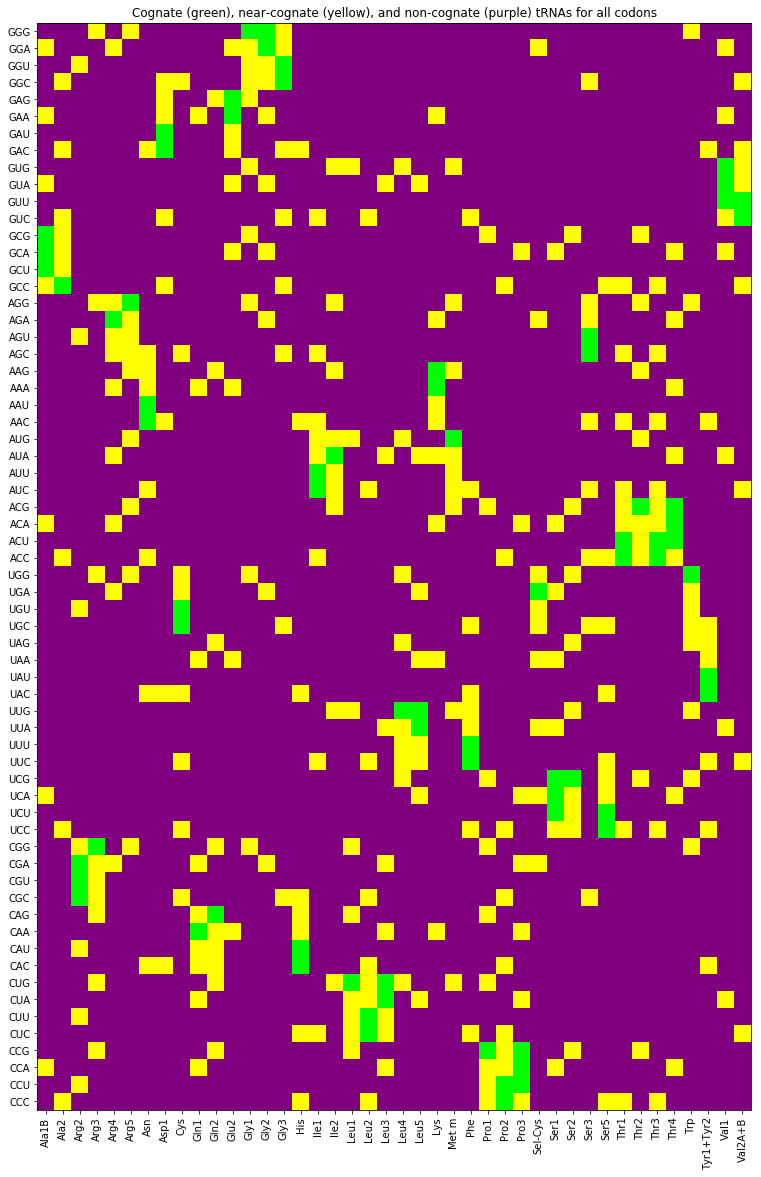

In [393]:
fig, ax1 = plt.subplots(figsize=(20, 20))
ax1.imshow(proximity_grid,cmap=colors.ListedColormap(['purple','yellow','lime']))
ax1.set_yticks(range(0,64));
ax1.set_yticklabels(codonlist);
ax1.set_xticks(range(0,42));
plt.xticks(rotation=90)
ax1.set_xticklabels(dict.keys());
ax1.set_title("Cognate (green), near-cognate (yellow), and non-cognate (purple) tRNAs for all codons")
####Should be 61 not 64???? (Fluitt 61, Rodnina 64?)
###Wrote up the table wrong. Each tRNA just has ONE anticodon, not 3...so should only be comparing to that main anticodon.
#But can't just give the 3rd base complete wobble for all combinations, since only some third bases wobble to cognates.
#So need to use the table 2 from dong
#How did Dong get the list of codon recognition patterns...maybe need to check his sources.

In [133]:
#Code to make a tRNA by tRNA grid
proximity_grid = np.zeros((len(dict.keys()),len(dict.keys())))
i=0
for tRNA1 in dict.keys():
    j=0
    for tRNA2 in dict.keys():
        for codon1 in dict[tRNA1]:
            if tRNA1!=tRNA2:
                max_neighbors=0
                
                for codon2 in dict[tRNA2]:
                    max_neighbors=neighbor_count(codon1,codon2)
                    if max_neighbors>proximity_grid[i,j]:
                        proximity_grid[i,j] = max_neighbors
        j+=1
    i+=1
    
def neighbor_count(tRNA1,tRNA2):
    count_diffs = 0
    for a, b in zip(tRNA1, tRNA2):
        if a!=b:
            count_diffs += 1
    if count_diffs == 1:
        return 1
    else: return 0

In [346]:
#Calculation of near-cognate binding time
k1 = 140
k1r = 85
k2=190
k2r=80
k3=0.4

t1 = 1000/k1

In [370]:
pr = (k1r/(k2+k1r))
t1r = 1000/k1r

In [371]:
pf = (k2/(k2+k1r))
t2 = 1000/k2

In [372]:
t2r = 1000/k2r

In [360]:
t1+pr*t1r+pf*(t2+t2r)*(1+pf+pf**2+pf**3+pf**4+pf**5+pf**6+pf**7+pf**8+pf**9+pf**10)

49.805140839114735

In [355]:
p3f = 0.4/(0.4+80)
t3 = 1000/0.4

In [359]:
t1+pr*t1r+pf*(t2+t2r)+pf*(t2+t2r)*(80/(80+0.4))*(pf+pf**2+pf**3+pf**4+pf**5+pf**6+pf**7+pf**8+pf**9+pf**10)+p3f*t3

62.109851322760676

In [361]:
#Should be using median time not mean like fluitt, since elongation 
#is a process happening in parallel, and because times aren't linear
#so we expect a few to be beyond k3 0.4, but most near-cognates
#to be kicked out far before that step.

In [395]:
k1 = 175
k1r = 700
k2=1500
k2r=800
#don't include k1 (transport time is what i'm including - make sure of this)
pr*t1r+pf*(t2+t2r)*(1+pf+pf**2+pf**3+pf**4+pf**5+pf**6+pf**7+pf**8+pf**9+pf**10+pf**11)

4.520234664403881

In [ ]:
#I need to solve the steady state probability distribution of the markov chain. 
#has rodnina 2014 already done this?

In [388]:
test=np.append(np.random.normal(1000,150,1),(np.random.normal(100,15,1)))
print(np.average(test))
print(np.std(test))

600.490781211
486.48263683


In [394]:
(pr*t1r+pf*(t2+t2r))/(1-pf)

5.535714285714285

In [418]:
a = 0.3
b =0.9
c = 0
for i in range(100):
    c+=(a*b)**i
c

1.36986301369863

In [419]:
1/(1-a*b)

1.36986301369863

In [573]:
#Cognate kinetics
k1r=717
k2f=1475
k2r_cog=2
k3_cog=1529
k4=208
k5_cog=200

t1r = 1000/k1r
t2f = 1000/k2f
t2r_cog = 1000/k2r_cog
t3_cog = 1000/k3_cog
t4 = 1000/k4
t5_cog = 1000/k5_cog

#Near-cognate kinetics
k1r=717
k2f=1475
k2r_nr = 1120
k3_nr = 6
k4=209

t2r_nr = 1000/k2r_nr
t3_nr = 1000/k3_nr

#Non-cognate kinetics
k1r=700

In [670]:
np.random.seed(1)
t1r_exp=np.random.exponential(t1r,size=4000)
t2f_exp=np.random.exponential(t2f,size=4000)
t2r_cog_exp=np.random.exponential(t2r_cog,size=4000)
t3_cog_exp=np.random.exponential(t3_cog,size=4000)
t4_exp=np.random.exponential(t4,size=4000)
t5_cog_exp=np.random.exponential(t5_cog,size=4000)

t2r_nr_exp=np.random.exponential(t2r_nr,size=4000)
t3_nr_exp=np.random.exponential(t3_nr,size=4000)


In [672]:
print(np.average(t1r_exp))
print(np.average(t2f_exp))
print(np.average(t2r_cog_exp))
print(np.average(t3_cog_exp))
print(np.average(t4_exp))
print(np.average(t5_cog_exp))
print(np.average(t2r_nr_exp))
print(np.average(t3_nr_exp))

1.38911816211
0.665434566868
500.189604083
0.656970516227
4.84078223589
5.01037325707
0.897391899922
163.434619959


(array([ 327981.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  672019.]),
 array([  1.39470014,   2.4369948 ,   3.47928946,   4.52158412,
          5.56387878,   6.60617344,   7.6484681 ,   8.69076277,
          9.73305743,  10.77535209,  11.81764675]),
 <a list of 10 Patch objects>)

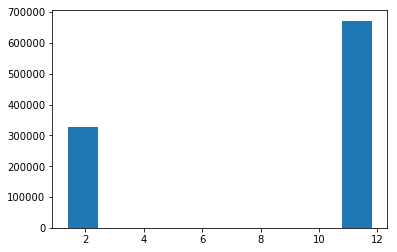

In [635]:
#Cognate kinetics
k1r=717
k2f=1475
k2r_cog=2
k3_cog=1529
k4=208
k5_cog=200

dwelltime_cog = list()


#Cognate calculation (average)
for i in range(1000000):
    dwell_t = 0
    state=1
    while state != 0 and state != 3:
        if state==1:
            if np.random.randint(0,k1r+k2f) < k1r:
                dwell_t+=t1r
                state=0
            else:
                dwell_t+=t2f
                state = 2
                
        if state==2:
            if np.random.randint(0,k2r_cog+k3_cog) < k2r_cog:
                #dwell_t+= t2r_cog
                state = 1
            else:
                dwell_t += t3_cog
                state = 3
        
        if state==3:
            dwell_t+=t4+t5_cog
            
    dwelltime_cog.append(dwell_t)
    
plt.hist(dwelltime_cog)
    
#Pick a number; if on right weighted side, do right action, if on left weighted side, left action.
#why is it proportional probability to go either direction if two pathways?


11.1312998827
1.39106991945
0.677558


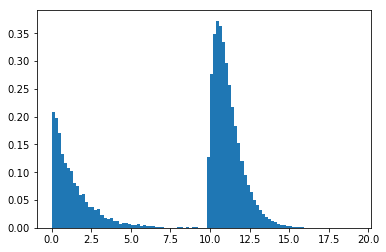

In [696]:
#Cognate calculation (distribution pulling from exponential)
dwelltime_cog_success = list()
dwelltime_cog_fail = list()

for i in range(1000000):
    dwell_t = 0
    state=1
    while state != 0 and state != 3:
        if state==1:
            if np.random.randint(0,k1r+k2f) < k1r:
                dwell_t+=np.random.choice(t1r_exp)
                dwelltime_cog_fail.append(dwell_t)
                state=0
                continue;
            else:
                dwell_t+=np.random.choice(t2f_exp)
                state = 2
                
        if state==2:
            if np.random.randint(0,k2r_cog+k3_cog) < k2r_cog:
                #dwell_t+= t2r_cog
                state = 1
            else:
                dwell_t += np.random.choice(t3_cog_exp)
                state = 3
        
        if state==3:
            dwell_t+=t4+t5_cog
            
    if state!=0: dwelltime_cog_success.append(dwell_t)


plt.hist(dwelltime_cog_success+dwelltime_cog_fail,bins=100,normed=True)
print(np.average(dwelltime_cog_success))
print(np.average(dwelltime_cog_fail))
print(len(dwelltime_cog_success)/(len(dwelltime_cog_success)+len(dwelltime_cog_fail)))


167.287780424
4.54655612799
4.39842666572


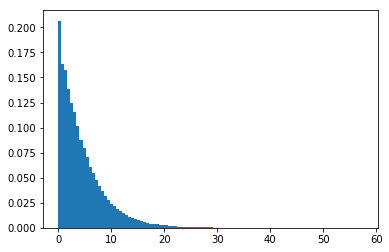

In [674]:
#Near-cognate calculation (distribution pulling from exponential)
dwelltime_nr_success = list()
dwelltime_nr_fail = list()
#Near-cognate kinetics
k1r=717
k2f=1475
k2r_nr = 1120
k3_nr = 6
k4=209

for i in range(1000000):
    dwell_t = 0
    state=1
    while state != 0 and state != 3:
        if state==1:
            if np.random.randint(0,k1r+k2f) < k1r:
                dwell_t+=np.random.choice(t1r_exp)
                dwelltime_nr_fail.append(dwell_t)
                state=0
                continue;
            else:
                dwell_t+=np.random.choice(t2f_exp)
                state = 2
                
        if state==2:
            if np.random.randint(0,k2r_nr+k3_nr) < k2r_nr:
                dwell_t+= np.random.choice(t2r_nr_exp)
                state = 1
            else:
                dwell_t += np.random.choice(t3_nr_exp)
                state = 3
                
    if state!=0: dwelltime_nr_success.append(dwell_t)

plt.hist(dwelltime_nr_fail,bins=100,normed=True)
print(np.average(dwelltime_nr_fail))
print(np.std(dwelltime_nr_fail))



1.39337214286


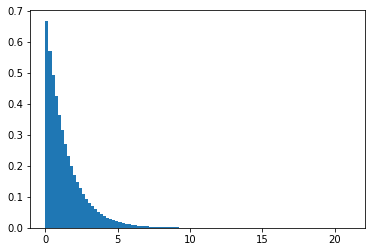

In [675]:
#Non-cognate calculation (distribution pulling from exponential)

#Non-cognate kinetics
k1r=700

t1rdist=(np.random.exponential(t1r,size=1000000))
plt.hist(t1rdist,bins=100,normed=True)
print(np.average(t1rdist))


Average cognate dwell time (successful): 11.1  ms
Average cognate dwell time (unsucessful): 1.4  ms
Proportion of succesful cognate incorporation vs. attempts 0.68
Average near cognate dwell time (unsuccesful) 4.5  ms
Average non-cognate dwell time (unsuccesful) 1.4 ms


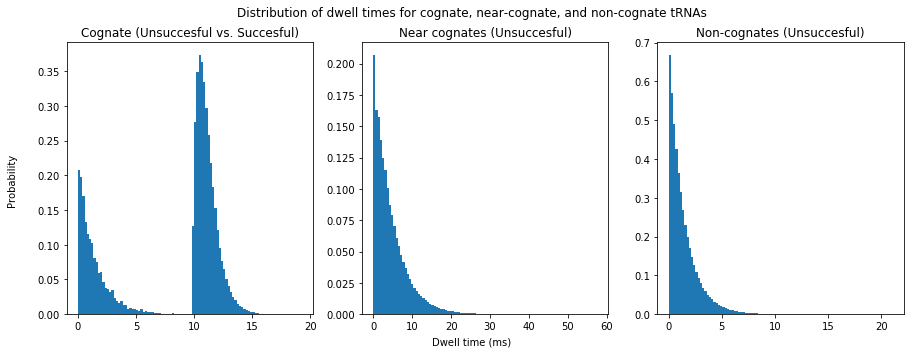

In [706]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Distribution of dwell times for cognate, near-cognate, and non-cognate tRNAs")

plt.subplot(1,3,1)
plt.hist(dwelltime_cog_success+dwelltime_cog_fail,bins=100,normed=True)
plt.title("Cognate (Unsuccesful vs. Succesful)")
plt.subplot(1,3,2)
plt.hist(dwelltime_nr_fail,bins=100,normed=True)
plt.title("Near cognates (Unsuccesful)")
plt.subplot(1,3,3)
plt.hist(t1rdist,bins=100,normed=True)
plt.title("Non-cognates (Unsuccesful)")

fig.text(0.5, 0.04, 'Dwell time (ms)', ha='center')
fig.text(0.07, 0.5, 'Probability', va='center', rotation='vertical')


print("Average cognate dwell time (successful):", round(np.average(dwelltime_cog_success),1), " ms")
print("Average cognate dwell time (unsucessful):", round(np.average(dwelltime_cog_fail),1), " ms")
print("Proportion of succesful cognate incorporation vs. attempts: ",round(len(dwelltime_cog_success)/(len(dwelltime_cog_success)+len(dwelltime_cog_fail)),2))
print("Average near cognate dwell time (unsuccesful)", round(np.average(dwelltime_nr_fail),1)," ms")
print("Average non-cognate dwell time (unsuccesful)", round(np.average(t1rdist),1), "ms")